In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]


In [2]:
data = ("/content/realistic_linear_regression_dataset.csv")

Columns in this dataset:


ProductCategory: Electronics, Clothing, Furniture, Toys

Region: North, South, East, West

CustomerSegment: Low Income, Middle Income, High Income

IsPromotionApplied: Yes, No

ProductionCost: Cost to produce the product

MarketingSpend: Marketing expenditure

SeasonalDemandIndex: Impact of seasonal demand

CompetitorPrice: Price of competing products

CustomerRating: Average customer rating out of 5

EconomicIndex: Economic conditions indicator

StoreCount: Number of stores selling the product

SalesRevenue: Target variable, revenue from sales

In [3]:
df=pd.read_csv(data)

In [4]:
df.head()

,ProductCategory,Region,CustomerSegment,IsPromotionApplied,ProductionCost,MarketingSpend,SeasonalDemandIndex,CompetitorPrice,CustomerRating,EconomicIndex,StoreCount,SalesRevenue
0,Furniture,East,High Income,Yes,536.051521,189.277811,1.159611,220.831351,4.035607,146.225757,52,2293.143707
1,Toys,West,High Income,No,352.701361,255.921497,1.545366,467.217175,4.106804,104.261304,35,1640.454368
2,Electronics,South,High Income,No,618.989105,277.399353,1.671902,363.623261,4.021775,77.220752,44,2173.086023
3,Furniture,West,Middle Income,Yes,339.959644,153.557699,1.408244,209.853621,4.148890,128.277455,15,1672.608857
4,Furniture,West,Middle Income,Yes,477.951385,155.814478,2.177301,274.859950,4.913782,111.309643,61,2443.222482


Text(0.5, 0.98, 'region  distibution')

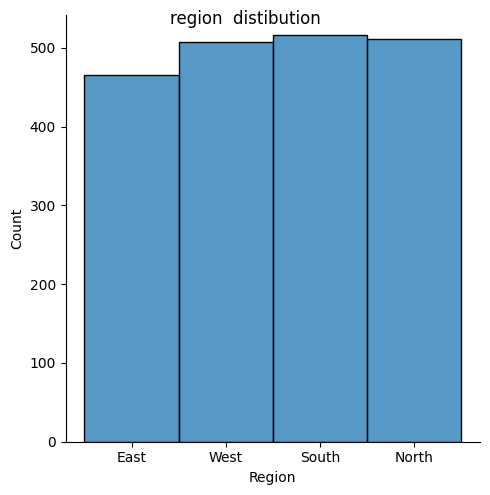

In [5]:
ax = sns.displot(data=df,x="Region",kind="hist",bins=25)
ax.fig.suptitle("region  distibution")

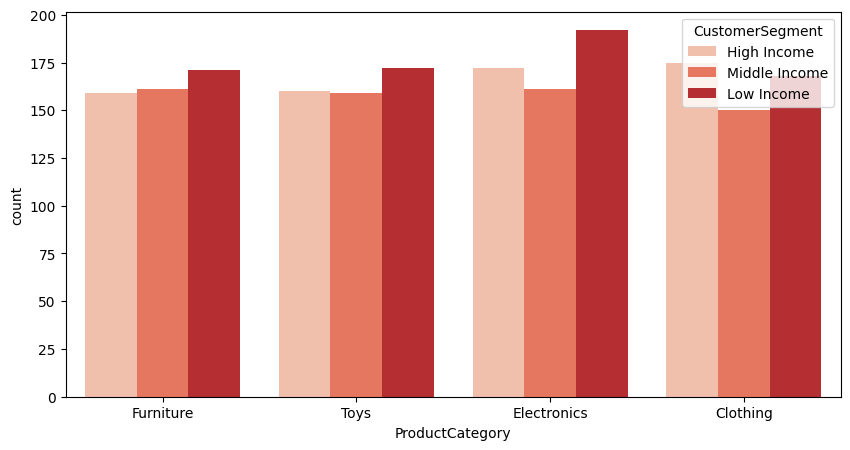

In [6]:
#check credit.policy
sns.countplot(x="ProductCategory",data=df, palette="Reds",hue="CustomerSegment")
plt.show()

In [7]:
df.isnull().sum()

,0
ProductCategory,0
Region,0
CustomerSegment,0
IsPromotionApplied,0
ProductionCost,0
MarketingSpend,0
SeasonalDemandIndex,0
CompetitorPrice,0
CustomerRating,0
EconomicIndex,0


In [8]:
df.describe()

,ProductionCost,MarketingSpend,SeasonalDemandIndex,CompetitorPrice,CustomerRating,EconomicIndex,StoreCount,SalesRevenue
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,499.969606,201.273420,1.484039,299.586427,3.999551,100.220798,48.674500,2072.857450
std,98.840116,49.953760,0.503743,81.524787,0.497141,19.176983,28.940548,346.007903
min,129.120339,46.777157,-0.527025,46.020085,2.449741,36.004789,1.000000,1094.518587
25%,434.452593,167.001091,1.150430,241.267538,3.656696,87.297706,23.000000,1808.106571
50%,500.600031,201.052487,1.485411,301.346897,3.985916,99.951705,49.000000,2068.173855
75%,566.588504,235.146602,1.826129,355.093381,4.338487,112.597996,74.000000,2341.223175
max,865.770180,379.973339,3.046715,552.443030,5.550593,164.320403,99.000000,3115.114292


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ProductCategory      2000 non-null   object 
 1   Region               2000 non-null   object 
 2   CustomerSegment      2000 non-null   object 
 3   IsPromotionApplied   2000 non-null   object 
 4   ProductionCost       2000 non-null   float64
 5   MarketingSpend       2000 non-null   float64
 6   SeasonalDemandIndex  2000 non-null   float64
 7   CompetitorPrice      2000 non-null   float64
 8   CustomerRating       2000 non-null   float64
 9   EconomicIndex        2000 non-null   float64
 10  StoreCount           2000 non-null   int64  
 11  SalesRevenue         2000 non-null   float64
dtypes: float64(7), int64(1), object(4)
memory usage: 187.6+ KB


In [11]:
df['PriceCompetitiveness'] = df['CompetitorPrice'] - df['ProductionCost']

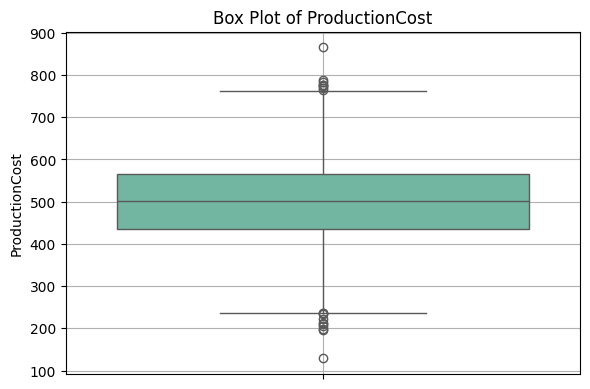

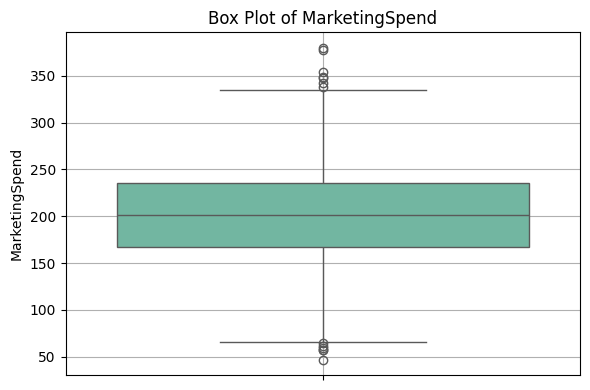

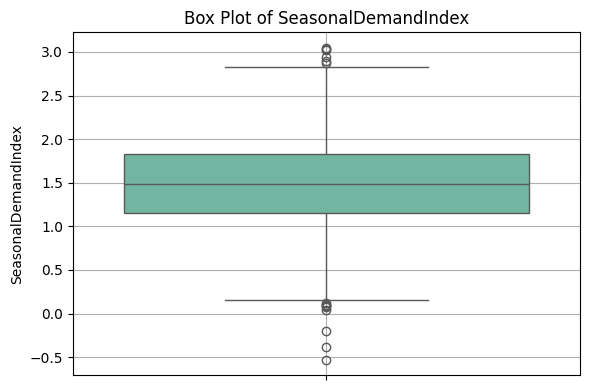

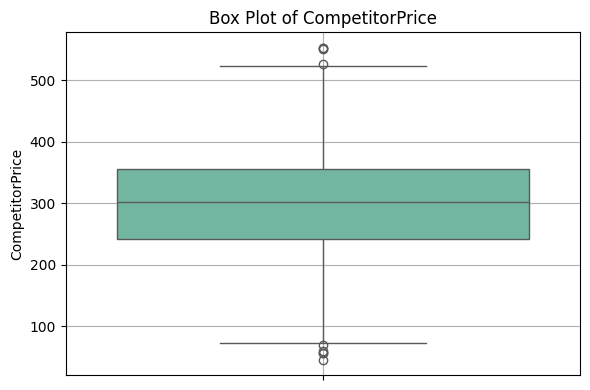

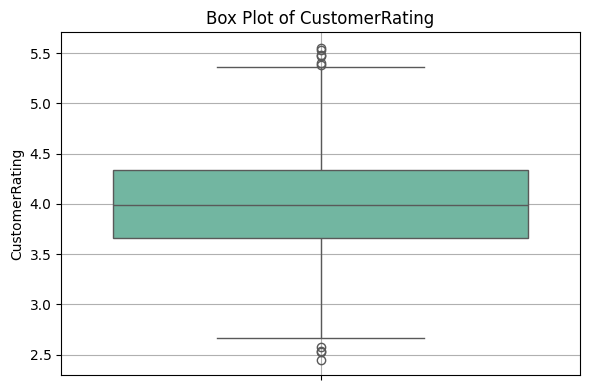

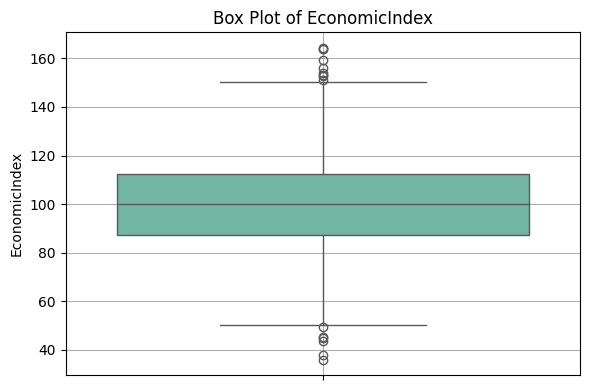

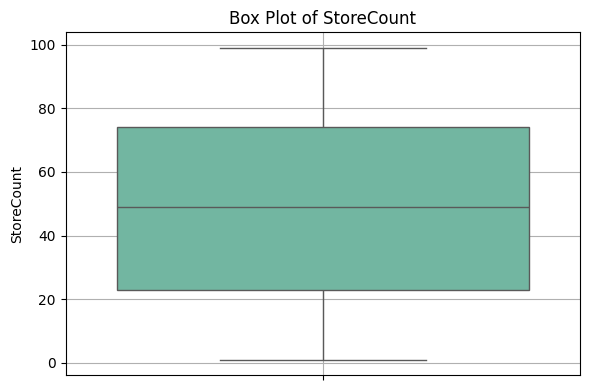

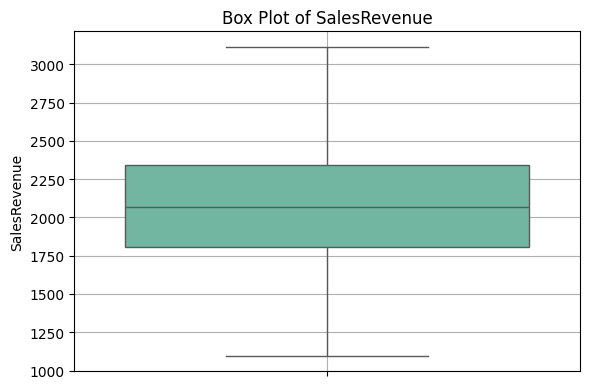

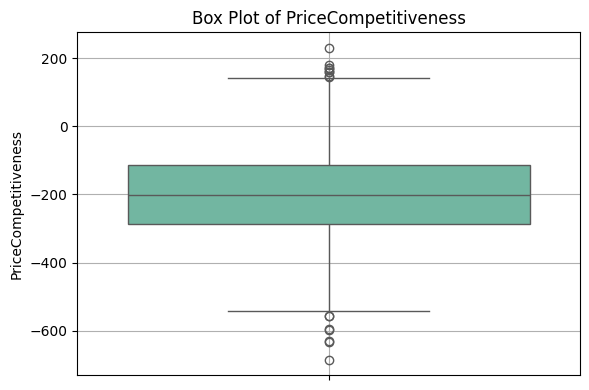

In [12]:
# Drop non-numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Plot individual box plots for each column
for column in df_numeric.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_numeric[column], palette='Set2')
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:


# Combine numerical with original non-numerical for final output (optional)
df_non_numeric = df.select_dtypes(exclude=['float64', 'int64'])

# Function to remove outliers using IQR
def remove_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# Remove outliers
df_cleaned_numeric = remove_outliers_iqr(df_numeric)

# Combine numeric and non-numeric data (if needed)
df_cleaned = pd.concat([df_cleaned_numeric.reset_index(drop=True), df_non_numeric.loc[df_cleaned_numeric.index].reset_index(drop=True)], axis=1)

# Result
print("Shape before removing outliers:", df.shape)
print("Shape after removing outliers:", df_cleaned.shape)

Shape before removing outliers: (2000, 13)
Shape after removing outliers: (1912, 13)


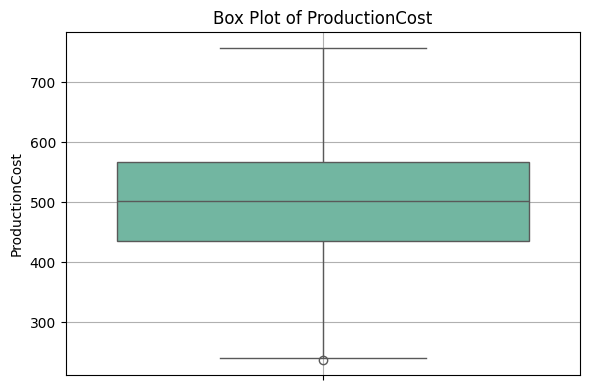

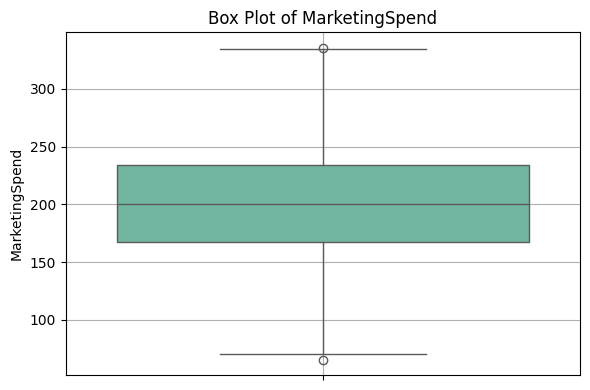

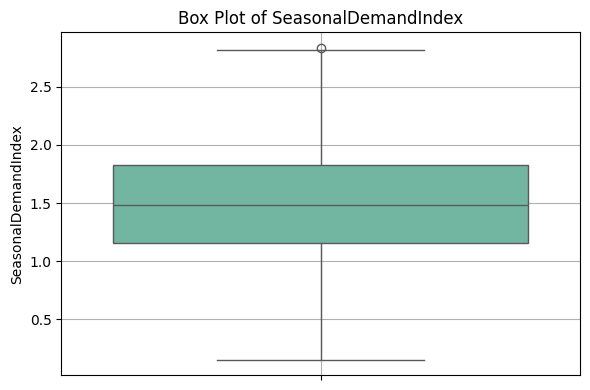

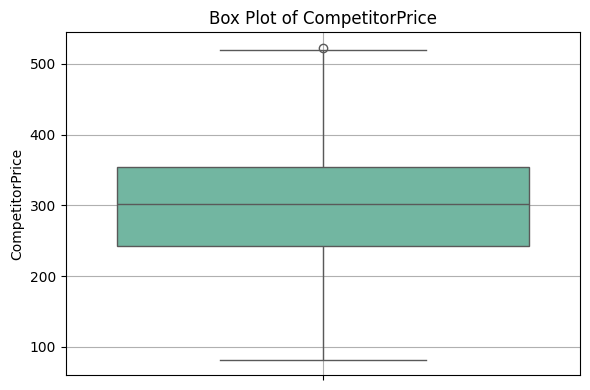

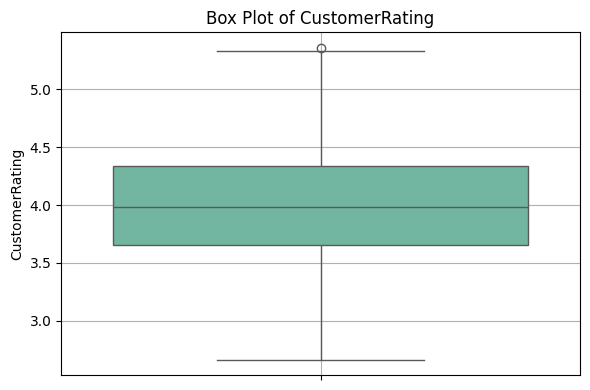

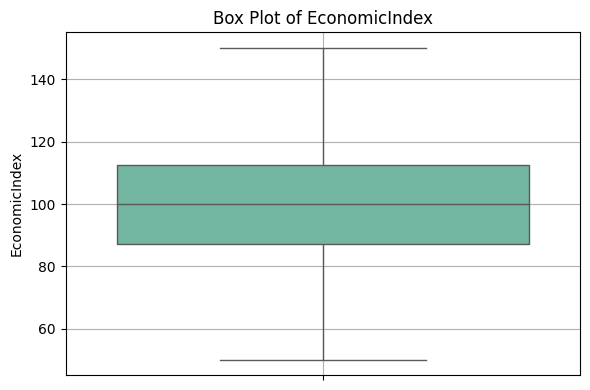

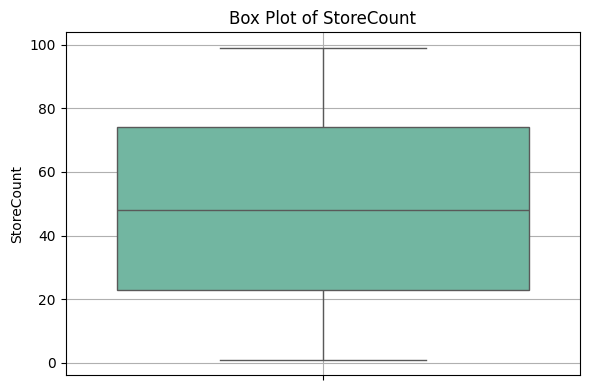

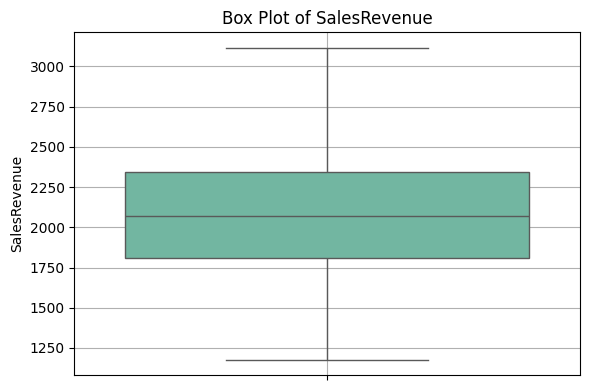

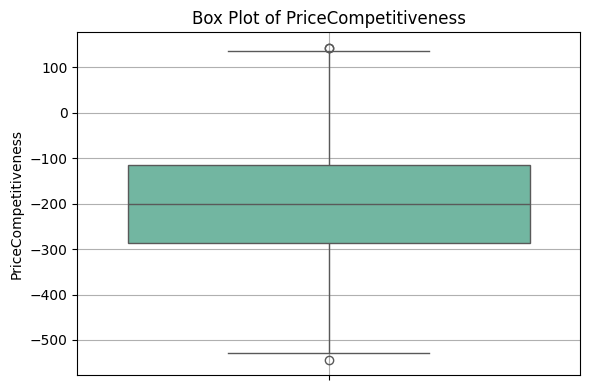

In [14]:
# Drop non-numeric columns
df_numeric = df_cleaned.select_dtypes(include=['float64', 'int64'])

# Plot individual box plots for each column
for column in df_numeric.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df_numeric[column], palette='Set2')
    plt.title(f'Box Plot of {column}')
    plt.ylabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
X = df_cleaned.drop('SalesRevenue', axis=1)
y = df_cleaned['SalesRevenue']



In [16]:
# Define features
num_features = ['ProductionCost', 'MarketingSpend', 'SeasonalDemandIndex',
                'CompetitorPrice', 'CustomerRating','EconomicIndex','StoreCount','PriceCompetitiveness']
cat_features_onehot = ['ProductCategory', 'Region', 'IsPromotionApplied']  # These will use one-hot
cat_features_ordinal = ['CustomerSegment']  # This will use ordinal

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), cat_features_onehot),
    ('cat_ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features_ordinal)
])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# XGBoost regressor
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Pipeline
model = Pipeline([
    ('preprocess', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', xgb)
])


In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV



# Parameter grid for tuning
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [2, 3, 4],
    'regressor__learning_rate': [0.03, 0.05, 0.1],
    'regressor__reg_alpha': [0, 0.1, 0.5],
    'regressor__reg_lambda': [1, 2, 3]
}
# # Set up GridSearchCV
# grid = GridSearchCV(model, param_grid, cv=10, scoring='r2', verbose=1)

# # Fit model
# grid.fit(X_train, y_train)

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(model, param_grid, cv=15, scoring='r2', n_iter=10, verbose=1)
random_search.fit(X_train, y_train)


# Best model
best_model = random_search.best_estimator_


Fitting 15 folds for each of 10 candidates, totalling 150 fits


In [34]:
# Predict on the test set
y_pred = best_model.predict(X_test)


# ✅ Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# ✅ Display results
print("✅ Test Set Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")



✅ Test Set Evaluation:
Root Mean Squared Error (RMSE): 112.76
Mean Absolute Error (MAE): 88.61
R² Score: 0.89


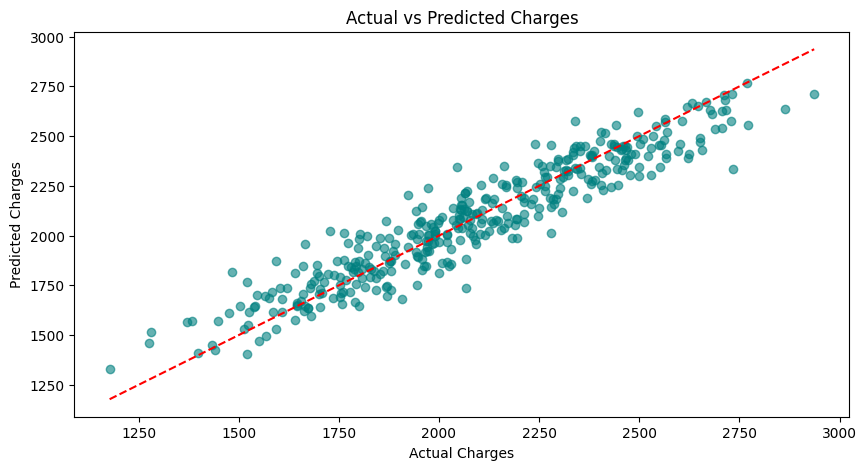

In [35]:
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()


In [ ]:
import joblib

# Save the best pipeline model
joblib.dump(random_search.best_estimator_, 'best_pipeline_model.joblib')

# Load the saved model
loaded_model = joblib.load('best_pipeline_model.joblib')


In [ ]:
#from google.colab import files

# Download the file to your local system
#files.download('best_pipeline_model.joblib')


In [39]:
import pandas as pd

new_data = pd.DataFrame({
    'ProductCategory': ['Electronics'],
    'Region': ['North'],
    'CustomerSegment': ['High Income'],
    'IsPromotionApplied': ['Yes'],
    'ProductionCost': [600],
    'MarketingSpend': [250],
    'SeasonalDemandIndex': [1.5],
    'CompetitorPrice': [320],
    'CustomerRating': [4.5],
    'EconomicIndex': [120],
    'StoreCount': [45]

})


# Create engineered feature
new_data['PriceCompetitiveness'] = new_data['CompetitorPrice'] - new_data['ProductionCost']

# Predict
prediction = random_search.predict(new_data)
print("Predicted Sales Revenue:", prediction[0])


Predicted Sales Revenue: 2310.0146
